In [1]:
import sys
# adding search_optimization_tools to the system path
sys.path.insert(0, '../')

In [2]:
import numpy as np
from search_optimization_tools.problems import TSP
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [3]:
# data can be found on https://github.com/coin-or/jorlib/tree/master/jorlib-core/src/test/resources/tspLib/tsp
# the following link is the permalink for berlin52
berlin52_tsp_url = 'https://raw.githubusercontent.com/coin-or/jorlib/b3a41ce773e9b3b5b73c149d4c06097ea1511680/jorlib-core/src/test/resources/tspLib/tsp/berlin52.tsp'

In [4]:
berlin52_tsp = TSP(load_tsp_url=berlin52_tsp_url)

In [5]:
cities = berlin52_tsp.cities
tsp_dist=berlin52_tsp.eval_distances_from_cities(cities)
tsp_dist_int=list(np.array(tsp_dist).astype(int))

In [6]:
def create_data_model():
    data = {}
    data['distance_matrix'] = tsp_dist_int
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

In [7]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

In [8]:
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)      

In [9]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [10]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH) # GREEDY_DESCENT, SIMULATED_ANNEALING, TABU_SEARCH, GENERIC_TABU_SEARCH
search_parameters.time_limit.seconds = 30
search_parameters.log_search = True

In [11]:
def print_solution(manager, routing, solution):
    print('Objective: {} meters'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}meters\n'.format(route_distance)

In [12]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

Objective: 7884 meters
Route for vehicle 0:
 0 -> 21 -> 31 -> 44 -> 18 -> 40 -> 7 -> 8 -> 9 -> 42 -> 32 -> 50 -> 11 -> 10 -> 51 -> 13 -> 12 -> 26 -> 27 -> 25 -> 46 -> 28 -> 29 -> 1 -> 6 -> 41 -> 20 -> 16 -> 2 -> 17 -> 30 -> 22 -> 19 -> 49 -> 15 -> 43 -> 45 -> 24 -> 3 -> 5 -> 14 -> 4 -> 23 -> 47 -> 37 -> 36 -> 39 -> 38 -> 33 -> 34 -> 35 -> 48 -> 0



In [13]:
def get_routes(solution, routing, manager):
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

In [14]:
routes = get_routes(solution, routing, manager)

for i, route in enumerate(routes):
  print('Route', i, route)

Route 0 [0, 21, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 11, 10, 51, 13, 12, 26, 27, 25, 46, 28, 29, 1, 6, 41, 20, 16, 2, 17, 30, 22, 19, 49, 15, 43, 45, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 33, 34, 35, 48, 0]


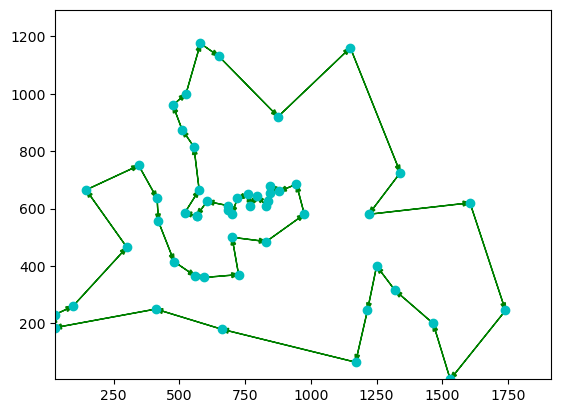

In [15]:
berlin52_tsp.plot(route)